In [2]:
# Dowload de bibliotecas
!pip -q install gdown imbalanced-learn fastapi uvicorn nest-asyncio

# Instalação de bibliotecas
import sys
from pathlib import Path
import importlib
import os
import zipfile
import gdown
from sklearn.linear_model import LogisticRegression

# caminho até a pasta scripts
scripts_path = Path("..") / "scripts"
sys.path.append(str(scripts_path))

# Import do script com as funções da equipe
import flight_delay_pipeline.py as scr
importlib.reload(scr)

ModuleNotFoundError: No module named 'flight_delay_pipeline.py'; 'flight_delay_pipeline' is not a package

In [2]:
# Carregar Dados
file_id = "1207psedBKvnS0pJkDITroSzPiWrcz0ag"

# Nome do arquivo que será baixado no Colab
zip_path = "dados_vra.zip"

# Se ainda não existir o zip, baixa do Drive
if not os.path.exists(zip_path):
    url = f"https://drive.google.com/uc?id={file_id}"
    print("Baixando arquivo do Drive...")
    gdown.download(url, zip_path, quiet=False)
else:
    print("Arquivo ZIP já existe, download interrompido.")

# Extrair o conteúdo do zip
extract_folder = "dados_vra"

if not os.path.exists(extract_folder):
    print("Extraindo arquivos do ZIP...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_folder)
else:
    print("Pasta de dados já existe.")

Arquivo ZIP já existe, download interrompido.
Pasta de dados já existe.


In [3]:
# Carregamento do Dataset
df = scr.carregar_dataset_base(
    pasta="/content/dados_vra/dados_vra",  # ajuste aqui se necessário
    sep=";",
    encoding="latin-1",
    skiprows=1,
    renomear=True,
    converter_datas=True,
)

df.head()

/content/script_v3.py:160: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")


,empresa_aerea,numero_voo,codigo_autorizacao_di,codigo_tipo_linha,aerodromo_origem,aerodromo_destino,partida_prevista,partida_real,chegada_prevista,chegada_real,situacao_voo,codigo_justificativa
0,TAM,3447,0,N,SBGR,SBFI,2021-01-09 20:25:00,2021-01-09 20:21:00,2021-01-09 22:05:00,2021-01-09 21:56:00,REALIZADO,NaN
1,TAM,3447,0,N,SBGR,SBFI,2021-01-10 20:25:00,2021-01-10 20:24:00,2021-01-10 22:05:00,2021-01-10 21:55:00,REALIZADO,NaN
2,TAM,3447,0,N,SBGR,SBFI,2021-01-11 20:25:00,2021-01-11 20:27:00,2021-01-11 22:05:00,2021-01-11 21:58:00,REALIZADO,NaN
3,TAM,3447,0,N,SBGR,SBFI,2021-01-12 20:25:00,2021-01-12 20:24:00,2021-01-12 22:05:00,2021-01-12 21:58:00,REALIZADO,NaN
4,TAM,3447,0,N,SBGR,SBFI,2021-01-13 20:25:00,2021-01-13 20:16:00,2021-01-13 22:05:00,2021-01-13 21:48:00,REALIZADO,NaN


Shape: (3968418, 12) | Amostra usada nos gráficos: 200,000


,dtype,pct_null,n_unique,example_values
codigo_justificativa,float64,100.00,0,-
chegada_real,datetime64[ns],4.20,1771272,"2021-01-09 21:56:00, 2021-01-10 21:55:00, 2021..."
partida_real,datetime64[ns],4.20,1745682,"2021-01-09 20:21:00, 2021-01-10 20:24:00, 2021..."
chegada_prevista,datetime64[ns],4.11,473587,"2021-01-09 22:05:00, 2021-01-10 22:05:00, 2021..."
partida_prevista,datetime64[ns],4.11,472200,"2021-01-09 20:25:00, 2021-01-10 20:25:00, 2021..."
codigo_tipo_linha,object,0.01,5,"N, I, G"
numero_voo,object,0.00,8691,"3447, 3448, 3449"
aerodromo_destino,object,0.00,616,"SBFI, SBSG, SBGR"
aerodromo_origem,object,0.00,603,"SBGR, MPTO, SSTE"
empresa_aerea,object,0.00,178,"TAM, CMP, OWT"


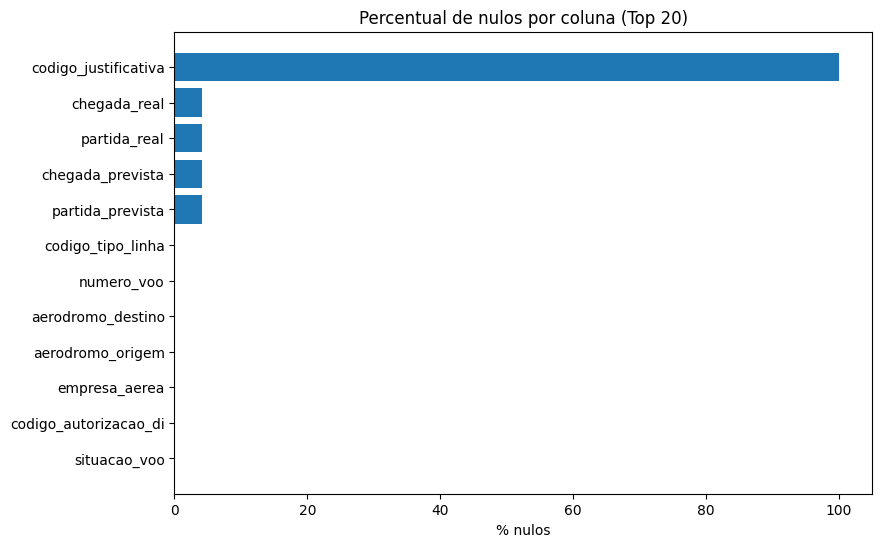

Numéricas plotadas: ['codigo_justificativa']
Categóricas plotadas: ['situacao_voo', 'codigo_tipo_linha', 'codigo_autorizacao_di', 'empresa_aerea', 'aerodromo_origem', 'aerodromo_destino']


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


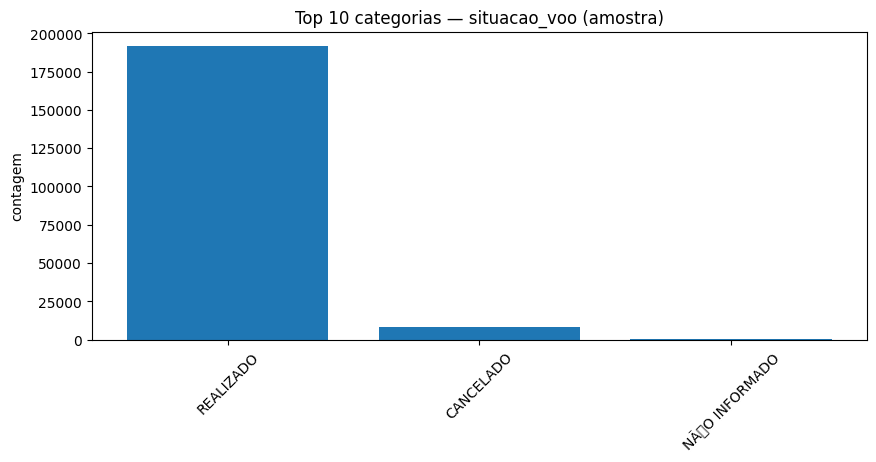

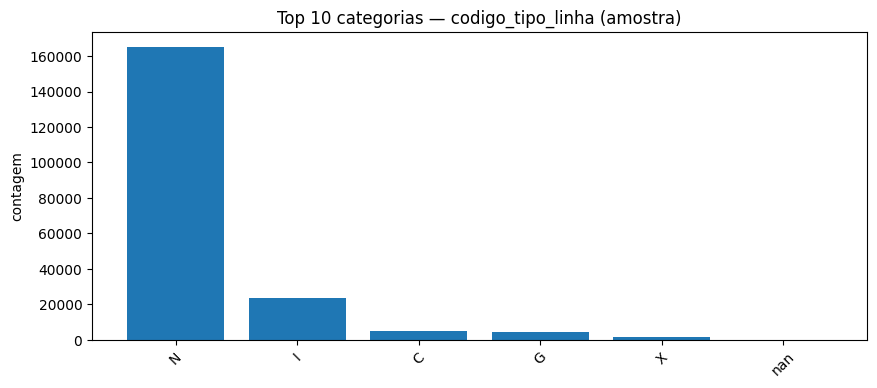

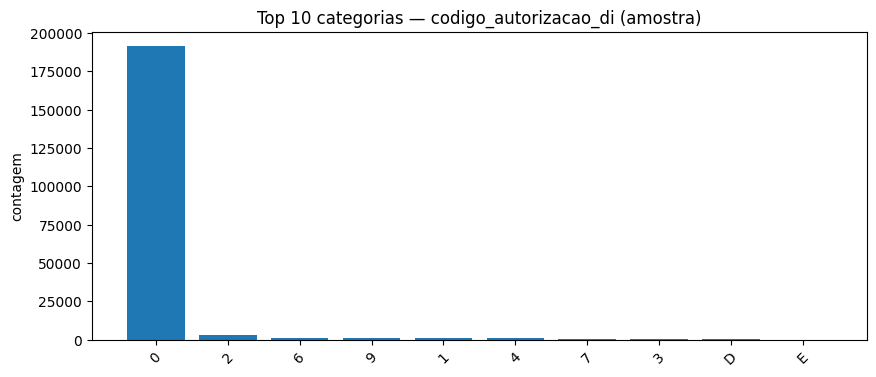

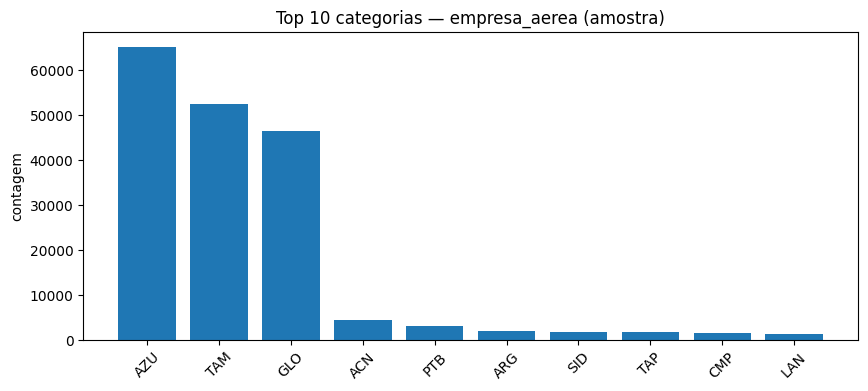

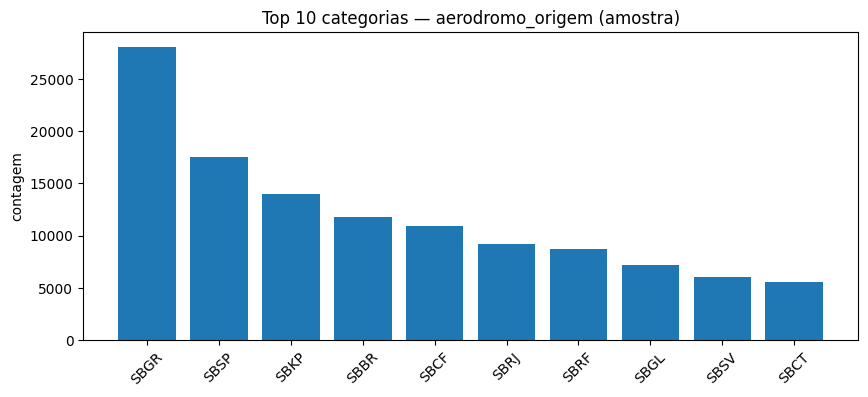

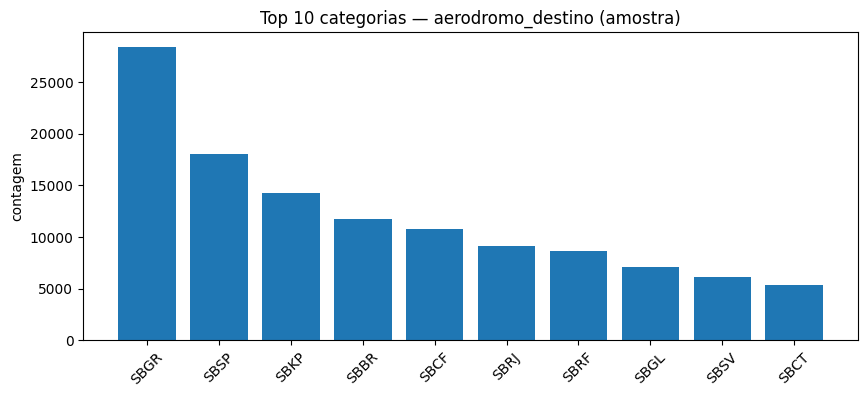

In [4]:
summary = scr.eda_viz(df, target=None)

In [5]:
df_flags = scr.criar_flags_qualidade_basicas(df)

df_flags[[
    "flag_partida_prevista_ausente",
    "flag_partida_real_ausente",
    "flag_data_fora_periodo"
]].mean()

,0
flag_partida_prevista_ausente,0.041119
flag_partida_real_ausente,0.042030
flag_data_fora_periodo,0.000000


In [6]:
df_model = scr.criar_target_atrasado(df_flags, limite_min=15)

df_model[scr.TARGET_COL].value_counts(normalize=True)
df_model.shape

(3644100, 17)

In [7]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644100 entries, 0 to 3968417
Data columns (total 17 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   empresa_aerea                  object        
 1   numero_voo                     object        
 2   codigo_autorizacao_di          object        
 3   codigo_tipo_linha              object        
 4   aerodromo_origem               object        
 5   aerodromo_destino              object        
 6   partida_prevista               datetime64[ns]
 7   partida_real                   datetime64[ns]
 8   chegada_prevista               datetime64[ns]
 9   chegada_real                   datetime64[ns]
 10  situacao_voo                   object        
 11  codigo_justificativa           float64       
 12  flag_partida_prevista_ausente  bool          
 13  flag_partida_real_ausente      bool          
 14  flag_data_fora_periodo         bool          
 15  atraso_partida_min  

In [9]:
df_train, df_test = scr.criar_split_estratificado(df_model, coluna_target=scr.TARGET_COL)
print('Formato dos dados de treino: ', df_train.shape)
print('Formato dos dados de teste: ', df_test.shape)

Formato dos dados de treino:  (2915280, 17)
Formato dos dados de teste:  (728820, 17)


In [10]:
# Definição das colunas que irão para o modelo
cfg = scr.FeatureConfig(
    numeric_features=[
        # criadas pelo função DatasFeaturesTransformer
        "hora_dia",
        "dia_semana",
        "mes_ano",
        "fim_de_semana",
        "alta_temporada",

        # criadas pelo pela função MediaAtrasoTransformer
        "media_atraso_empresa",
        "media_atraso_origem",
        "media_atraso_destino",
    ],
    categorical_features=[
        # originais
        "empresa_aerea",
        "codigo_tipo_linha",
        "aerodromo_origem",
        "aerodromo_destino",
        "situacao_voo",

        # criada pela função DatasFeaturesTransformer
        "periodo_dia",
    ],
)

In [12]:
# Treinamento do Modelo
model = LogisticRegression(max_iter=200)

out = scr.treinar_classificador(
    df_train=df_train,
    df_test=df_test,
    cfg=cfg,
    model=model,
    target=scr.TARGET_COL,
    use_smote=False
)

pipe = out["pipeline"]
metrics = out["metrics"]

metrics["confusion_matrix"], metrics.get("roc_auc")

([[607521, 4743], [109541, 7015]], 0.6595962785874027)

In [13]:
# Salvar o modelo (pkl)
MODEL_PATH = "artifacts/flightontime_pipeline.pkl"
scr.salvar_pickle(pipe, MODEL_PATH)

In [14]:
# Escrever a API
%%writefile api_app.py
import script_v3 as scr

MODEL_PATH = "artifacts/flightontime_pipeline.pkl"
app = scr.criar_app_fastapi(MODEL_PATH)

Overwriting api_app.py


In [15]:
# Executar a API no ambiente interno
!pkill -f uvicorn || true
!nohup uvicorn api_app:app --host 0.0.0.0 --port 8000 > uvicorn.log 2>&1 &
!sleep 2
!tail -n 20 uvicorn.log

^C


In [18]:
# Fazer a requisição do JSON
import requests
print(requests.get("http://127.0.0.1:8000/health").json())

{'status': 'ok'}


In [19]:
# Envio dos novos dados de entrada
payload = {
  "dados": {
    "partida_prevista": "2025-12-25 10:30:00",
    "empresa_aerea": "GOL",
    "codigo_tipo_linha": "Regular",
    "aerodromo_origem": "SBSP",
    "aerodromo_destino": "SBGL",
    "situacao_voo": "Realizado"
  }
}

r = requests.post("http://127.0.0.1:8000/predict", json=payload)
print(r.status_code)
print(r.text)  # se der erro, aparece aqui


200
{"prediction":0,"proba_atraso":0.4824187760521761}


In [17]:
# Checagem de erros da API
!tail -n 120 uvicorn.log

INFO:     Started server process [39056]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
